Load a time series of MODIS (MxD11_L2) LST observations from a directory

In [1]:
import xarray as xr
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from scipy import interpolate
import cartopy.crs as ccrs

%matplotlib inline

Find all HDF files in a specified directory

In [2]:
def getListOfFiles(dirName,ext):
    '''Create a list of file names in the given directory with specified file extension.'''
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Only match files with the correct extension
        if '.'+ext == os.path.splitext(entry)[1]:
            # Create full path and add to list
            fullPath = os.path.join(dirName, entry)
            allFiles.append(fullPath)       
    return allFiles

In [3]:
searchDir = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MODIS\Tuolumne_2017_MxD11_L2'
file_list = getListOfFiles(searchDir,'hdf')

Open all the datasets

In [4]:
datasets = [xr.open_dataset(path, chunks={}) for path in file_list]

Inspect the datasets

In [5]:
datasets

[<xarray.Dataset>
 Dimensions:     (Along_swath_lines_1km:MOD_Swath_LST: 2030, Coarse_swath_lines_5km:MOD_Swath_LST: 406, Coarse_swath_pixels_5km:MOD_Swath_LST: 271, Cross_swath_pixels_1km:MOD_Swath_LST: 1354)
 Dimensions without coordinates: Along_swath_lines_1km:MOD_Swath_LST, Coarse_swath_lines_5km:MOD_Swath_LST, Coarse_swath_pixels_5km:MOD_Swath_LST, Cross_swath_pixels_1km:MOD_Swath_LST
 Data variables:
     Latitude    (Coarse_swath_lines_5km:MOD_Swath_LST, Coarse_swath_pixels_5km:MOD_Swath_LST) float32 dask.array<shape=(406, 271), chunksize=(406, 271)>
     Longitude   (Coarse_swath_lines_5km:MOD_Swath_LST, Coarse_swath_pixels_5km:MOD_Swath_LST) float32 dask.array<shape=(406, 271), chunksize=(406, 271)>
     LST         (Along_swath_lines_1km:MOD_Swath_LST, Cross_swath_pixels_1km:MOD_Swath_LST) float32 dask.array<shape=(2030, 1354), chunksize=(2030, 1354)>
     QC          (Along_swath_lines_1km:MOD_Swath_LST, Cross_swath_pixels_1km:MOD_Swath_LST) uint16 dask.array<shape=(2030, 1

Define a function to interpolate from the coarse resolution latitude and longitude to the same resolution as the LST SDS

In [6]:
def interpLatLon(ds):
    '''Given a MODIS (MxD11_L2) xarray.Dataset (ds), interpolate between arrays of Latitude and Longitude values.
       Return a dataset with Lat/Lon arrays of the correct size to match the LST SDS.'''
    
    x = ds['Coarse_swath_pixels_5km:MOD_Swath_LST'].values # swath pixels, along-track (x values)
    y = ds['Coarse_swath_lines_5km:MOD_Swath_LST'].values # swath lines, cross-track (y values)
    xx, yy = np.meshgrid(x, y) # Create meshgrid of pixel/line values
    # Create pixel/line coordinates for between the coarse pixels (1/scale_factor)
    scale_factor = 5
    step = 1 / scale_factor
    offset = 2
    xnew = np.arange(0-(offset*step), ds['Coarse_swath_pixels_5km:MOD_Swath_LST'].shape[0]-(offset*step), step)
    ynew = np.arange(0-(offset*step), ds['Coarse_swath_lines_5km:MOD_Swath_LST'].shape[0]-(offset*step), step)
    
    # Interpolate within the Latitude array
    z_lat = ds.Latitude.values
    fn_lat = interpolate.interp2d(x, y, z_lat, kind='linear')
    znew_lat = fn_lat(xnew, ynew)
    if znew_lat.shape[1] > ds.LST.shape[1]: # if our interpolated Latitude array is longer than the LST SDS
        znew_lat = znew_lat[:,0:ds.LST.shape[1]] # make it them same shape
    # Add new Latitudes to MODIS dataset
    lat = xr.DataArray(znew_lat, dims=['Along_swath_lines_1km:MOD_Swath_LST', 'Cross_swath_pixels_1km:MOD_Swath_LST'])
    ds['Latitude_1km'] = lat
    
    # Interpolate within the Longitude array
    z_lon = ds.Longitude.values
    fn_lon = interpolate.interp2d(x, y, z_lon, kind='linear')
    znew_lon = fn_lon(xnew, ynew)
    if znew_lon.shape[1] > ds.LST.shape[1]: # if our interpolated Longitude array is longer than the LST SDS
        znew_lon = znew_lon[:,0:ds.LST.shape[1]] # make it them same shape
    # Add new Longitudes to MODIS dataset
    lon = xr.DataArray(znew_lon, dims=['Along_swath_lines_1km:MOD_Swath_LST', 'Cross_swath_pixels_1km:MOD_Swath_LST'])
    ds['Longitude_1km'] = lon
    
    # Set coordinates to the newly interpolated Lat and Lon values
    #ds.reset_coords(drop=True)
    ds = ds.set_coords(['Longitude_1km', 'Latitude_1km'])
    
    return ds

Create a new dataset with this function, with the newly interpolated Latitude and Longitude values

In [7]:
datasets_new = [interpLatLon(dataset) for dataset in datasets]

Find the LST value for a pixel at a specific location specified by a latitude and longitude

And make some plots around our area of interest

In [66]:
lat_obs = 37.88 #approx locaiton of Gaylor Pit
long_obs=-119.31
temp=[]
datetime=[]
b=0.5 #bounds, +/- in degrees lat/lon
n=0
for f in datasets_new:
    # Find LST value at the specified coordinates
    coordinates = np.unravel_index((np.abs(f.Latitude_1km - lat_obs) + np.abs(f.Longitude_1km - long_obs)).argmin(), f.Latitude_1km.shape)
    temp.append(f.LST[coordinates].values)
    
    # Find the date and time of this observation
    i = f.attrs['CoreMetadata.0'].find('RANGEBEGINNINGDATE')
    date = f.attrs['CoreMetadata.0'][i+80:i+90]
    i = f.attrs['CoreMetadata.0'].find('RANGEBEGINNINGTIME')
    time = f.attrs['CoreMetadata.0'][i+80:i+95]
    datetime.append(pd.to_datetime('{} {}'.format(date,time)))
    
    # print and save figure
    fig, ax = plt.subplots(figsize=(7,7))
    ax = plt.axes(projection=ccrs.Orthographic(-117, 39))
    f.LST.plot.pcolormesh('Longitude_1km', 'Latitude_1km',cmap='magma',
                          vmin=250, vmax=350, ax=ax, transform=ccrs.PlateCarree(),zorder=30);
    #ax.set_global(); #ax.stock_img();
    ax.coastlines();
    ax.gridlines();
    ax.set_extent([long_obs-b,long_obs+b, lat_obs-b,lat_obs+b], crs=ccrs.PlateCarree())
    ax.set_title('MODIS LST {}'.format(datetime[n]))
    plt.savefig('figures/MODIS LST {}.png'.format(n))
    plt.close('all')
    n+=1

d = {'datetime': datetime, 'temperature': temp}
modis = pd.DataFrame(data=d)
modis['temperature'] = modis['temperature']-273.15
modis['datetime'] +=  pd.to_timedelta(-7, unit='h')
modis = modis.sort_values('datetime').reset_index()

Load Gaylor Pit snow surface temperature data

In [54]:
# Gaylor Pit surface temperature data
filepath = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\GaylorPit\GaylorPit2017_039_T15min.csv'
gaylor = pd.read_csv(filepath)

# Make some data type and unit conversions
gaylor['datetime'] = pd.to_datetime(gaylor['TIMESTAMP']) # timestamp string to pandas datetime
gaylor['Judd_Air_TempC'] = (gaylor['Judd_Air_TempF'] - 32) / 1.8 # temperature F to temperature C
gaylor['Judd_Depth_cm'] = gaylor['Judd_Depth_in'] * 2.54 # snowdepth inches to snowdepth cm


Plot MODIS LST and Gaylor Pit temperature data together

Text(0.5, 1.0, 'Surface Temperatures')

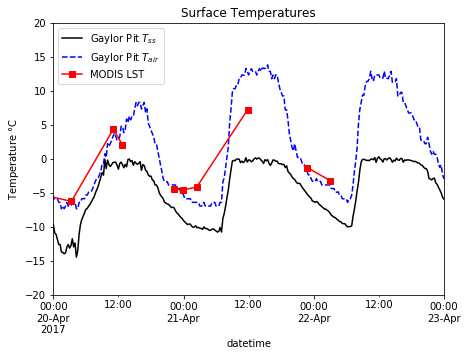

In [63]:
starttime = pd.to_datetime('2017-04-20')
endtime = pd.to_datetime('2017-04-23')

fig, ax = plt.subplots(figsize=(7,5))

gaylor.plot(x='datetime',y='TT_C', color='k', ax=ax, label= 'Gaylor Pit $T_{ss}$')
gaylor.plot(x='datetime',y='Judd_Air_TempC', linestyle='--', color='b', ax=ax, label= 'Gaylor Pit $T_{air}$')
modis.plot(x='datetime',y='temperature',marker='s',color='r',ax=ax,label='MODIS LST')

ax.set_xlim((starttime,endtime))
ax.set_ylim((-20,20))
ax.set_ylabel('Temperature $\degree$C');
ax.set_title('Surface Temperatures')

In [64]:
modis

,index,datetime,temperature
0,0,2017-04-19 23:05:00,-5.49
1,8,2017-04-20 03:20:00,-6.29001
2,1,2017-04-20 11:05:00,4.36999
3,2,2017-04-20 12:45:00,1.99001
4,9,2017-04-20 14:25:00,NaN
5,3,2017-04-20 22:10:00,-4.41001
6,4,2017-04-20 23:50:00,-4.59
7,10,2017-04-21 02:25:00,-4.19001
8,5,2017-04-21 11:50:00,7.23
9,11,2017-04-21 13:30:00,NaN
